In [2]:
from sklearn.model_selection import cross_validate, LeaveOneGroupOut
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import networkx as nx

import sys
sys.path.append("..")
sys.path.append("../d2c/")
from utils import print_dag, dag_to_formula, show_dag

import pickle

#suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score



In [3]:
# df = pd.read_csv('../data/ts3_descriptors_with_cycles.csv')  # replace with your data file
df = pd.read_csv('../data/ts5_descriptors_with_cycles.csv')  # replace with your data file
# df = pd.read_csv('../data/ts_limited_descriptors.csv')  # replace with your data file



In [4]:
df = df.drop_duplicates(subset=['graph_id', 'edge_source', 'edge_dest'], keep='first').reset_index(drop=True)

In [5]:
df.to_csv('../data/ts5_fixed_descriptors_with_cycles.csv', index=False)

In [6]:
graph_info = df[['graph_id','edge_source','edge_dest']]
X = df.drop(columns=['graph_id','edge_source','edge_dest', 'is_causal'])
y = df['is_causal']

In [7]:
#data stats
print('Number of samples:', len(X))
print('Number of features:', len(X.columns))
print('Number of causal edges:', y.sum())
print('Number of non-causal edges:', len(y) - y.sum())
print('Number of graphs:', len(df['graph_id'].unique()))


Number of samples: 45000
Number of features: 92
Number of causal edges: 7506
Number of non-causal edges: 37494
Number of graphs: 1500


In [8]:
X

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,...,Feature82,Feature83,Feature84,Feature85,Feature86,Feature87,Feature88,Feature89,Feature90,Feature91
0,0.067796,-0.278205,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,6,0.039735,74.614333,54.953306,8.021390,-6.115111,1.610458,2.093956,6.924163,29.032334
1,0.295755,0.491573,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,6,0.039735,74.614333,47.240373,8.021390,3.299974,6.012510,5.909580,48.113067,63.583511
2,-1.349899,-0.639216,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,6,0.039735,68.182631,74.614333,-1.307289,8.021390,-5.958614,4.944538,-64.568580,-54.991321
3,-1.242661,-0.821586,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,6,0.039735,68.182631,54.953306,-1.307289,-6.115111,3.631621,-1.655760,-47.200093,-52.719084
4,-0.228380,-0.228380,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,6,0.039735,68.182631,71.318126,-1.307289,8.148340,-3.230397,8.093250,-39.795642,-23.885010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,-0.186399,-0.140454,0.027863,0.000126,0.000041,0.00000,0.00000,0.00000,0.00000,0.00000,...,6,0.039474,28.719160,23.782017,2.566904,0.261256,2.081316,0.140297,2.256394,-5.944817
44996,-0.129243,0.022077,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,6,0.039474,36.426137,25.202182,-3.535397,2.978243,1.302877,1.697962,7.858334,2.893543
44997,0.254317,0.217834,0.060171,0.060171,0.024847,0.01921,0.01921,0.01921,0.01921,0.01921,...,6,0.039474,36.426137,36.455159,-3.535397,-5.574772,-2.869700,-5.365685,21.306027,26.227298
44998,-0.063341,-0.104350,0.057916,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,...,6,0.039474,36.426137,23.782017,-3.535397,0.261256,-0.459624,1.196496,-11.115187,0.494992


In [9]:
with open('../data/ts5.pkl', 'rb') as f:
    observations, dags, updated_dags = pickle.load(f)

With Naive

In [93]:

#train test split 
logo = LeaveOneGroupOut()
groups = df['graph_id']
brf_scores = pd.DataFrame(columns=['accuracy_train','precision_train','recall_train', 'f1_train', 'auc_train', 'accuracy_test', 'precision_test', 'recall_test', 'f1_test', 'auc_test', 'accuracy_naive', 'precision_naive', 'recall_naive', 'f1_naive', 'auc_naive', 'accuracy_random', 'precision_random', 'recall_random','f1_random', 'auc_random'])
counter = 0
predicted_values = {}
predicted_probabilities = {}
real_values = {}
for train_index, test_index in logo.split(X, y, groups):
    current_group = groups[test_index[0]]
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    brf = BalancedRandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, n_jobs=-1)
    brf.fit(X_train, y_train)



    accuracy_train = brf.score(X_train, y_train)
    precision_train = precision_score(y_train, brf.predict(X_train))
    recall_train = recall_score(y_train, brf.predict(X_train))
    f1_train = f1_score(y_train, brf.predict(X_train))
    auc_train = roc_auc_score(y_train, brf.predict_proba(X_train)[:,1])

    predicted_probs = brf.predict_proba(X_test)[:,1]
    threshold = 0.8  # for example
    predicted_labels = (predicted_probs > threshold).astype(int)

    # accuracy_test = brf.score(X_test, y_test)
    # precision_test = precision_score(y_test, brf.predict(X_test))
    # recall_test = recall_score(y_test, brf.predict(X_test))
    # f1_test = f1_score(y_test, brf.predict(X_test))
    # auc_test = roc_auc_score(y_test, brf.predict_proba(X_test)[:,1])

    accuracy_test = brf.score(X_test, y_test)
    precision_test = precision_score(y_test, predicted_labels)
    recall_test = recall_score(y_test, predicted_labels)
    f1_test = f1_score(y_test, predicted_labels)
    auc_test = roc_auc_score(y_test, brf.predict_proba(X_test)[:,1])

    naive_predictions = np.zeros(len(y_test))
    accuracy_naive = np.mean(naive_predictions == y_test)
    precision_naive = precision_score(y_test, naive_predictions, zero_division=0)
    recall_naive = recall_score(y_test, naive_predictions)
    f1_naive = f1_score(y_test, naive_predictions)
    auc_naive = roc_auc_score(y_test, naive_predictions)

    random_predictions = np.random.randint(0,2,len(y_test))
    accuracy_random = np.mean(random_predictions == y_test)
    precision_random = precision_score(y_test, random_predictions)
    recall_random = recall_score(y_test, random_predictions)
    f1_random = f1_score(y_test, random_predictions)
    auc_random = roc_auc_score(y_test, random_predictions)

    

    predicted_values[len(brf_scores)] = brf.predict(X_test)
    predicted_probabilities[len(brf_scores)] = brf.predict_proba(X_test)[:,1]
    real_values[len(brf_scores)] = y_test

    brf_scores.loc[len(brf_scores)] = [accuracy_train, precision_train, recall_train, f1_train, auc_train, accuracy_test, precision_test, recall_test, f1_test, auc_test, accuracy_naive, precision_naive, recall_naive, f1_naive, auc_naive, accuracy_random, precision_random, recall_random, f1_random, auc_random]


    counter += 1
    if counter == 20:
        break

c:\ProgramData\Anaconda3\envs\d2c\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\d2c\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\d2c\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\ProgramData\Anaconda3\envs\d2c\lib\site-packages\sklearn\metrics\_classification.py:1469

In [94]:
brf_scores

,accuracy_train,precision_train,recall_train,f1_train,auc_train,accuracy_test,precision_test,recall_test,f1_test,auc_test,accuracy_naive,precision_naive,recall_naive,f1_naive,auc_naive,accuracy_random,precision_random,recall_random,f1_random,auc_random
0,0.781677,0.433152,0.999067,0.604304,0.947985,0.933333,1.000000,1.000000,1.000000,1.000000,0.933333,0.0,0.0,0.0,0.5,0.633333,0.153846,1.000000,0.266667,0.803571
1,0.780076,0.431317,0.998934,0.602492,0.948065,0.900000,0.600000,1.000000,0.750000,0.975309,0.900000,0.0,0.0,0.0,0.5,0.500000,0.071429,0.333333,0.117647,0.425926
2,0.782077,0.433382,0.999200,0.604552,0.947256,0.633333,1.000000,0.777778,0.875000,0.936508,0.700000,0.0,0.0,0.0,0.5,0.600000,0.400000,0.666667,0.500000,0.619048
3,0.780943,0.432286,0.999467,0.603534,0.947633,0.866667,0.750000,0.750000,0.750000,0.980769,0.866667,0.0,0.0,0.0,0.5,0.500000,0.076923,0.250000,0.117647,0.394231
4,0.780543,0.431847,0.999067,0.603033,0.948111,0.900000,1.000000,1.000000,1.000000,1.000000,0.900000,0.0,0.0,0.0,0.5,0.566667,0.142857,0.666667,0.235294,0.611111
5,0.781143,0.432453,0.999600,0.603720,0.947472,0.800000,0.833333,0.833333,0.833333,0.965278,0.800000,0.0,0.0,0.0,0.5,0.333333,0.111111,0.333333,0.166667,0.333333
6,0.781032,0.432328,0.999600,0.603599,0.947546,0.733333,0.666667,0.666667,0.666667,0.916667,0.800000,0.0,0.0,0.0,0.5,0.333333,0.150000,0.500000,0.230769,0.395833
7,0.780832,0.432016,0.998666,0.603125,0.947782,0.800000,1.000000,0.714286,0.833333,0.962733,0.766667,0.0,0.0,0.0,0.5,0.466667,0.235294,0.571429,0.333333,0.503106
8,0.780987,0.432280,0.999067,0.603455,0.947766,0.766667,0.833333,1.000000,0.909091,0.992000,0.833333,0.0,0.0,0.0,0.5,0.500000,0.222222,0.800000,0.347826,0.620000
9,0.781010,0.432305,0.999067,0.603479,0.947529,0.833333,0.500000,0.600000,0.545455,0.936000,0.833333,0.0,0.0,0.0,0.5,0.500000,0.187500,0.600000,0.285714,0.540000


In [68]:
brf_scores_old = pd.read_csv('ts5_brf_scores.csv')

In [74]:
pd.concat([brf_scores_old['precision_test'],brf_scores['precision_test'],brf_scores_old['recall_test'],brf_scores['recall_test'] ],axis=1)

,precision_test,precision_test,recall_test,recall_test
0,0.500000,1.000000,1.000000,1.000000
1,0.500000,1.000000,1.000000,1.000000
2,0.450000,0.875000,1.000000,0.777778
3,0.500000,0.750000,1.000000,0.750000
4,0.500000,1.000000,1.000000,1.000000
5,0.500000,0.833333,1.000000,0.833333
6,0.428571,0.666667,1.000000,0.666667
7,0.545455,0.833333,0.857143,0.714286
8,0.416667,0.833333,1.000000,1.000000
9,0.555556,0.500000,1.000000,0.600000


In [17]:
predicted_values

{0: array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0], dtype=int64),
 1: array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 0], dtype=int64),
 2: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 1], dtype=int64),
 3: array([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 0], dtype=int64),
 4: array([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0], dtype=int64),
 5: array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 6: array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 0], dtype=int64),
 7: array([0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0], dtype=int64),
 8: arra

In [95]:
all_labels = np.concatenate([predicted_values[i] for i in predicted_values.keys()])
all_probs = np.concatenate([predicted_probabilities[i] for i in predicted_probabilities.keys()])

In [96]:
pre_postprocessing = pd.concat([graph_info, pd.DataFrame(all_labels, columns=['predicted_label']), pd.DataFrame(all_probs, columns=['predicted_probabilities'])], axis=1).head(600)

In [97]:
pre_postprocessing.to_csv('ts5_pre_postprocessing.csv', index=False)

In [98]:
pre_postprocessing.loc[pre_postprocessing.graph_id == 12]

,graph_id,edge_source,edge_dest,predicted_label,predicted_probabilities
360,12,0,1,1.0,0.703975
361,12,1,2,1.0,0.862202
362,12,3,0,1.0,0.773427
363,12,3,1,1.0,0.727642
364,12,4,0,1.0,0.717428
365,12,5,0,1.0,0.772018
366,12,5,2,1.0,0.862291
367,12,0,2,0.0,0.002504
368,12,0,3,1.0,0.615608
369,12,0,4,1.0,0.710519


In [99]:
# Reload the CSV file
data = pd.read_csv('ts5_pre_postprocessing.csv')

# Filter data to get only rows with predicted_label as 1
causal_edges = data[data['predicted_label'] == 1]

# Find pairs (i,j) and (j,i) both with label 1 and within the same graph_id
pairs = []
for _, row in causal_edges.iterrows():
    reverse_edge = causal_edges[
        (causal_edges['graph_id'] == row['graph_id']) & 
        (causal_edges['edge_source'] == row['edge_dest']) & 
        (causal_edges['edge_dest'] == row['edge_source'])
    ]
    
    if not reverse_edge.empty:
        pair = (row['graph_id'], row['edge_source'], row['edge_dest'])
        reverse_pair = (row['graph_id'], row['edge_dest'], row['edge_source'])
        
        # Avoid duplicate pairs
        if reverse_pair not in pairs:
            pairs.append(pair)

# Convert to DataFrame
identified_pairs_df = pd.DataFrame(pairs, columns=['graph_id', 'edge_source', 'edge_dest'])

identified_pairs_df.head()

# For each identified pair (i,j) and (j,i)
for _, row in identified_pairs_df.iterrows():
    # Extract the pairs' details
    graph_id, i, j = row['graph_id'], row['edge_source'], row['edge_dest']
    
    # Get the rows for (i,j) and (j,i)
    edge_ij = data[(data['graph_id'] == graph_id) & (data['edge_source'] == i) & (data['edge_dest'] == j)]
    edge_ji = data[(data['graph_id'] == graph_id) & (data['edge_source'] == j) & (data['edge_dest'] == i)]
    
    # Compare their probabilities and update the one with the lower probability
    if edge_ij.iloc[0]['predicted_probabilities'] < edge_ji.iloc[0]['predicted_probabilities']:
        data.at[edge_ij.index[0], 'predicted_label'] = 0
        data.at[edge_ij.index[0], 'predicted_probabilities'] = 0
    else:
        data.at[edge_ji.index[0], 'predicted_label'] = 0
        data.at[edge_ji.index[0], 'predicted_probabilities'] = 0

# Display the updated data
data.head()


,graph_id,edge_source,edge_dest,predicted_label,predicted_probabilities
0,0,1,2,1.0,0.907619
1,0,1,5,1.0,0.874365
2,0,0,1,0.0,0.000031
3,0,0,2,0.0,0.000031
4,0,0,3,0.0,0.000031


In [100]:
data['truth'] = y.head(600)
data['predicted_label_before'] = pd.read_csv('ts5_pre_postprocessing.csv')['predicted_label']
data['predicted_probabilities_before'] = pd.read_csv('ts5_pre_postprocessing.csv')['predicted_probabilities']

In [101]:
len(data.predicted_label_before)

600

In [102]:
(data.predicted_label == data.predicted_label_before).sum()

487

In [103]:
accuracy = np.mean(data['truth'] == data['predicted_label'])
precision = precision_score(data['truth'], data['predicted_label'])
recall = recall_score(data['truth'], data['predicted_label'])
f1 = f1_score(data['truth'], data['predicted_label'])
auc = roc_auc_score(data['truth'], data['predicted_probabilities'])

old_accuracy = np.mean(data['truth'] == data['predicted_label_before'])
old_precision = precision_score(data['truth'], data['predicted_label_before'])
old_recall = recall_score(data['truth'], data['predicted_label_before'])
old_f1 = f1_score(data['truth'], data['predicted_label_before'])
old_auc = roc_auc_score(data['truth'], data['predicted_probabilities_before'])

pd.DataFrame([[accuracy, precision, recall, f1, auc], [old_accuracy, old_precision, old_recall, old_f1, old_auc]], columns=['accuracy', 'precision', 'recall', 'f1', 'auc'], index=['after', 'before'])


,accuracy,precision,recall,f1,auc
after,0.908333,0.700000,0.815534,0.753363,0.830615
before,0.780000,0.437768,0.990291,0.607143,0.954758


In [104]:
predicted_values[12]

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1], dtype=int64)

In [125]:

#handle a single graph
graph_id = 9

info = data.loc[data['graph_id'] == graph_id]
pred_causes = info['predicted_label']
pred_probs = info['predicted_probabilities']
real_causes = info['truth']

In [126]:
info

,graph_id,edge_source,edge_dest,predicted_label,predicted_probabilities,truth,predicted_label_before,predicted_probabilities_before
270,9,0,4,1.0,0.941588,1,1.0,0.941588
271,9,0,5,1.0,0.887288,1,1.0,0.887288
272,9,1,3,0.0,0.000000,1,1.0,0.635467
273,9,2,1,0.0,0.000000,1,1.0,0.632589
274,9,3,5,1.0,0.858123,1,1.0,0.858123
275,9,0,1,0.0,0.048627,0,0.0,0.048627
276,9,0,2,0.0,0.003333,0,0.0,0.003333
277,9,0,3,1.0,0.837485,0,1.0,0.837485
278,9,1,0,0.0,0.021329,0,0.0,0.021329
279,9,1,2,1.0,0.882450,0,1.0,0.882450


In [127]:
info.to_csv('temp_results.csv')

In [128]:

results = pd.read_csv('temp_results.csv')

In [129]:


#construct dag from pred_causes
import sys
sys.path.append("..")
sys.path.append("../d2c/")
from utils import print_dag, dag_to_formula, show_dag
import numpy as np
import pandas as pd
import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(np.unique(np.append(results.edge_source.unique(),results.edge_dest.unique())))

for value in results.iterrows():
    if value[1]['predicted_label'] == 1:
        G.add_edge(int(value[1]['edge_source']), int(value[1]['edge_dest']), color='blue', weight=value[1]['predicted_probabilities'])




In [130]:


#construct dag from pred_causes
import sys
sys.path.append("..")
sys.path.append("../d2c/")
from utils import print_dag, dag_to_formula, show_dag
import numpy as np
import pandas as pd
import networkx as nx
G2 = nx.DiGraph()
G2.add_nodes_from(np.unique(np.append(results.edge_source.unique(),results.edge_dest.unique())))

for value in results.iterrows():
    if value[1]['predicted_label_before'] == 1:
        G2.add_edge(int(value[1]['edge_source']), int(value[1]['edge_dest']), color='blue', weight=value[1]['predicted_probabilities_before'])




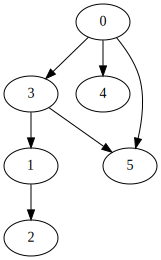

In [131]:

show_dag(G, weight=False)


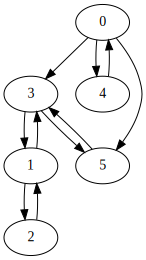

In [132]:

show_dag(G2, weight=False)


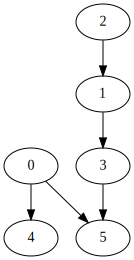

In [133]:
show_dag(dags[graph_id],weight=False)

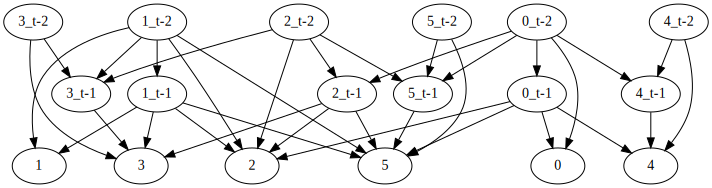

In [135]:
show_dag(updated_dags[0],weight=False)

In [140]:
observations[16]

,0,1,2,3,4,5
0,-0.02660,-0.55195,-0.78765,0.51062,0.24256,0.92540
1,-0.81900,0.92665,0.95981,0.37012,0.68256,0.39340
2,-0.36410,-0.09811,0.30265,-0.05611,0.11396,-0.16547
3,-0.04134,-0.07350,-0.24842,0.05581,0.14239,-0.28989
4,0.03721,-0.08510,-0.02424,-0.02412,0.16825,0.15417
...,...,...,...,...,...,...
146,0.00043,0.00164,0.00115,-0.00175,-0.00123,-0.00233
147,0.00414,0.00398,-0.00450,-0.00299,0.00129,-0.00205
148,0.00191,0.00707,-0.00353,-0.00249,-0.00001,-0.00062
149,0.00202,0.00539,-0.00385,0.00169,-0.00131,0.00009
